In [0]:
!pip3 install tensorflow_text>=2.0.0rc0

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=3619ef86f03f9d4e10ad2b5513cfa430c83361e4ce195371b6fc3c86dc39f7ad
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


IndexError: ignored

In [0]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text # Not used directly but needed to import TF ops.

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import pickle

In [0]:
path_to_model = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
train = pd.read_parquet('drive/My Drive/Colab Notebooks/train.parquet'); train.head()

,question,_call_4_collaboration,_jobs,_random_b,_random_politics,_random_talks,article_essence,audio_and_speech,bayesian,big_data,bioinformatics,blockchain,business,career,class_coursera_aml,class_cs231n,class_dl_cmu,class_fastai,class_udacity_pytorch,cloud,conference,cv,data_breakfast,data_fest,datasets,deep_learning,deephack,devops,dlcourse_ai,ds_process,edu_academy,edu_books,edu_courses,edu_shad_exams,gis,gnomiki,hardware,interesting_links,kaggle_crackers,lang_cpp,lang_go,lang_python,lang_r,lang_scala,looking_for_a_job,math,medicine,ml_pipeline,mlcourse_ai,mlcourse_ai_news,mlcourse_ai_rus,mltrainings_beginners,mltrainings_live,network_analysis,nlp,ods_habr,ods_merch,ods_policy_prior,ods_resume_mastering,ods_sport,ods_sport_sf,ods_travel,picsartaihack,randomcoffee,recommender_systems,reinforcement_learning,satellite_imaging,sberbank_contest,security,self_driving,sequences_series,theory_and_practice,tool_albumentations,tool_catalyst,tool_catboost,tool_dvc,trading,visualization,welcome,writing_n_presenting
0,за hw9/10 баллы в рейтинг будут?,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,По поводу кассандры – а как ее разворачивать в...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,При покупке на localbitcoin есть ли какие-то г...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Что посоветуете брать, поддержаную gtx 1080 ti...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Всем привет. Может кто-нибудь встречал описани...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
val = pd.read_parquet('drive/My Drive/Colab Notebooks/val.parquet')

In [0]:
with open('drive/My Drive/Colab Notebooks/label_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)

In [0]:
X_train, y_train = train['question'], train.drop('question', axis=1)
X_val, y_val = val['question'], val.drop('question', axis=1)

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0,  
                                                  name='categorical_crossentropy')
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1,
                                                  patience=4, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint('drive/My Drive/Colab Notebooks/checkpoints/USE_classif.h5', monitor='val_auc', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='max', save_freq='epoch')
reduse_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=2, verbose=1, mode='max',
                              min_delta=0.001, cooldown=1, min_lr=1e-9)

In [0]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.AUC(name='auc', multi_label=True, label_weights=list(class_weights.values()))]

In [0]:
question = Input(shape=(1,), dtype=tf.string, name='Question')
use = hub.KerasLayer(path_to_model, trainable=True, name='USE')
#encode questions
q_emb = use(tf.squeeze(tf.cast(question, tf.string)))
#dense layer
dropout = tf.keras.layers.Dropout(0.2)(q_emb)
preds = Dense(len(class_weights), activation='softmax', name='Dense')(dropout)
model = Model(inputs=question, outputs=preds)
model.compile(loss=loss_fn, optimizer=opt, run_eagerly=True, metrics=METRICS)

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Question (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
tf_op_layer_Squeeze (TensorF [None]                    0         
_________________________________________________________________
USE (KerasLayer)             (None, 512)               68927232  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Dense (Dense)                (None, 79)                40527     
Total params: 68,967,759
Trainable params: 68,967,759
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_hist = model.fit(X_train, y_train,
                       batch_size=64,
                       epochs=20,
                       validation_data=(X_val, y_val),
                       callbacks=[early_stopping, checkpoint, reduse_lr],
                       class_weight=class_weights)

Epoch 1/20
3361/3361 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.1312 - auc: 0.6628
Epoch 00001: val_auc improved from -inf to 0.84372, saving model to drive/My Drive/Colab Notebooks/checkpoints/USE_classif.h5
3361/3361 [==============================] - 897s 267ms/step - loss: 0.0740 - accuracy: 0.1312 - auc: 0.6628 - val_loss: 4.1841 - val_accuracy: 0.2564 - val_auc: 0.8437 - lr: 1.0000e-05
Epoch 2/20
3361/3361 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.3138 - auc: 0.8909
Epoch 00002: val_auc improved from 0.84372 to 0.92660, saving model to drive/My Drive/Colab Notebooks/checkpoints/USE_classif.h5
3361/3361 [==============================] - 880s 262ms/step - loss: 0.0701 - accuracy: 0.3138 - auc: 0.8909 - val_loss: 3.9891 - val_accuracy: 0.3763 - val_auc: 0.9266 - lr: 1.0000e-05
Epoch 3/20
3361/3361 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.4065 - auc: 0.9414
Epoch 00003: val_auc improved from 0.

In [0]:
#load model
model = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/checkpoints/USE_classif.h5', custom_objects={'KerasLayer': hub.KerasLayer})
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Question (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
tf_op_layer_Squeeze (TensorF None                      0         
_________________________________________________________________
USE (KerasLayer)             (None, 512)               68927232  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Dense (Dense)                (None, 79)                40527     
Total params: 68,967,759
Trainable params: 68,967,759
Non-trainable params: 0
_________________________________________________________________


In [0]:
test = pd.read_parquet('drive/My Drive/Colab Notebooks/test.parquet')
annos = test.columns[1:]
features, labels = test['question'], test.drop('question', axis=1)
del test

In [0]:
preds = model.predict(features, batch_size=32)
labels = tf.math.argmax(labels, axis=1, output_type=tf.dtypes.int32)
preds = tf.math.argmax(preds, axis=1, output_type=tf.dtypes.int32)

In [0]:
weights = []
for pred in preds:
    weights.append(class_weights[pred.numpy()])

In [0]:
cm = tf.math.confusion_matrix(labels, preds, num_classes=None, weights=None, dtype=tf.dtypes.int32, name=None)
cm

<tf.Tensor: shape=(79, 79), dtype=int32, numpy=
array([[186,   2,   0, ...,   0,   3,   0],
       [  2, 321,   1, ...,   0,   0,   0],
       [  0,   0, 929, ...,   0,   0,   0],
       ...,
       [  0,   0,   3, ..., 419,   0,   0],
       [  0,   0,   0, ...,   0, 184,   0],
       [  0,   0,   0, ...,   0,   0,  28]], dtype=int32)>

Normilizing confusion matrix

In [0]:
cm = cm.numpy()

In [0]:
row_sums = cm.sum(axis=1)
cm = cm / row_sums[:, np.newaxis]
cm

array([[0.85714286, 0.00921659, 0.        , ..., 0.        , 0.01382488,
        0.        ],
       [0.00615385, 0.98769231, 0.00307692, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.87066542, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00601202, ..., 0.83967936, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.91542289,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.96551724]])

Sorting confusion matrix

In [0]:
sorting_idx = np.argsort(np.diag(cm))[::-1]
sorting_idx

array([60, 28, 59, 74, 47,  1, 19, 29, 56,  5, 58, 57, 78, 68, 30, 34, 75,
       43,  9, 52, 35, 10, 45, 63, 42, 62, 44,  6, 55,  7, 72, 54, 67, 71,
       77, 64, 38, 73, 69, 26, 33, 11, 31, 17,  8,  2, 13, 39, 23, 32,  0,
       12, 18, 53, 22, 16, 36,  3, 76, 20, 21, 48, 51, 66, 37, 41, 65, 40,
       27, 46, 61, 25, 24, 15, 70,  4, 14, 50, 49])

In [0]:
sorted_cm = cm[sorting_idx,:][:,sorting_idx]
sorted_cm

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.28061224, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03268551,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01013514,
        0.00337838]])

In [0]:
sorted_annos = []
for id in sorting_idx:
  sorted_annos.append(annos[id])

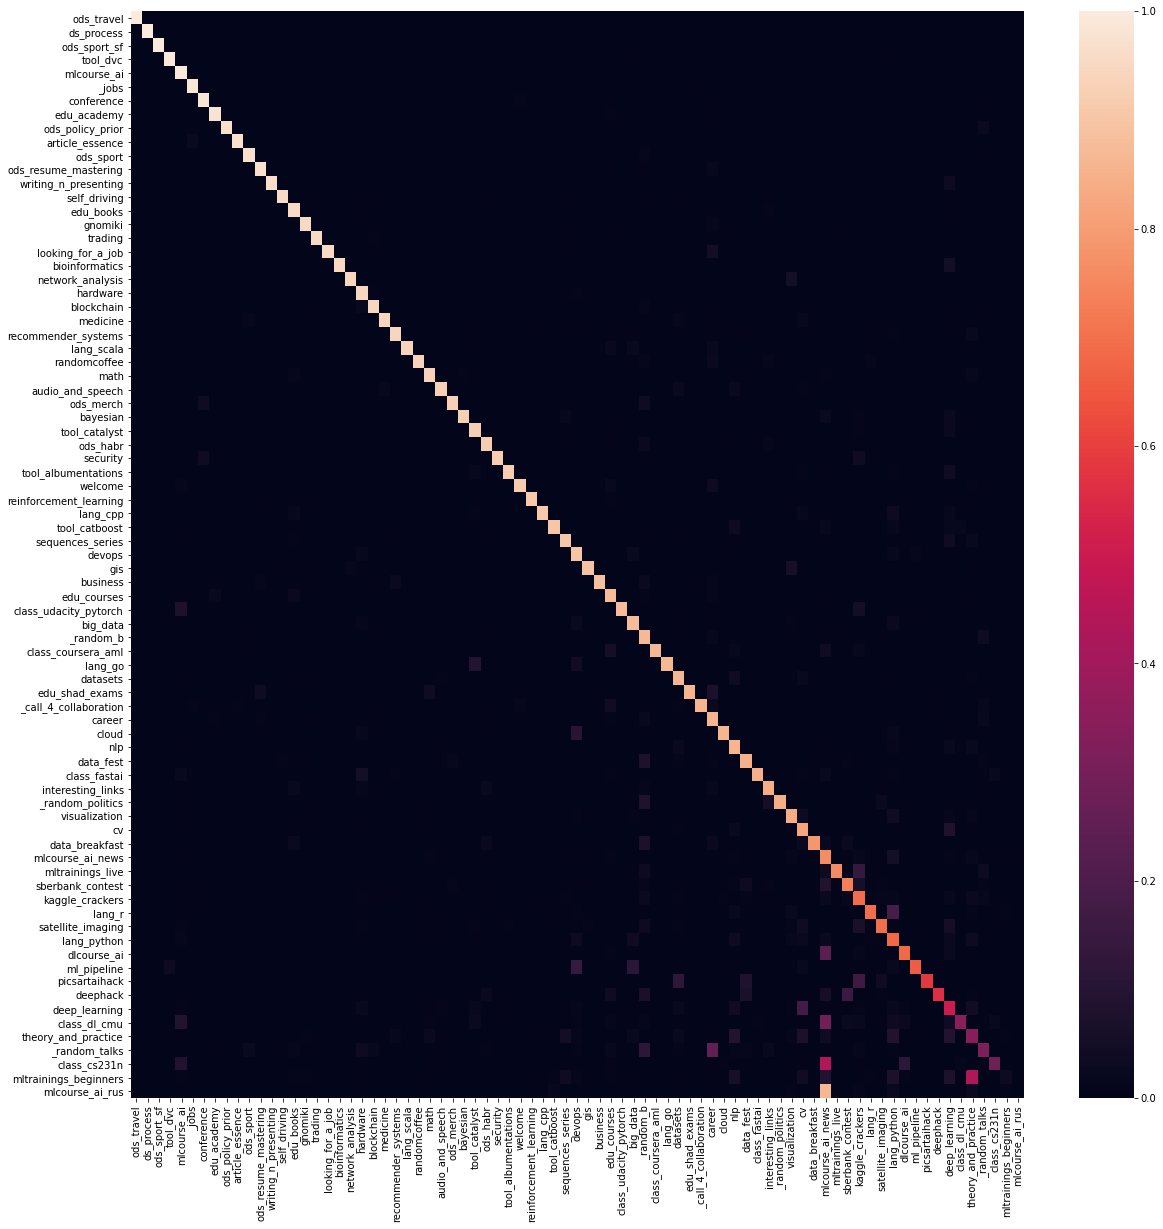

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(sorted_cm, vmax=1, xticklabels=sorted_annos, yticklabels=sorted_annos)
fig.savefig('drive/My Drive/Colab Notebooks/sorted_heatmap.svg')

In [0]:
model.evaluate(features, labels, batch_size=32)

2241/2241 [==============================] - 79s 35ms/step - loss: 1.8255 - accuracy: 0.6933 - auc: 0.9920


[1.8255269527435303, 0.6933110356330872, 0.991972804069519]

Computing AUC-ROC via sklearn

In [0]:
from sklearn.metrics import roc_auc_score

Remake predictions, because sklearn wants distribution

In [0]:
preds = model.predict(features, batch_size=32)

In [0]:
roc_auc_score(labels, preds, average='macro', sample_weight=None, max_fpr=None, multi_class='ovo', labels=None)

0.9848252806552208